In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import re
sns.set_theme(style="darkgrid")


In [6]:
original_df = pd.read_csv('./input/train.csv')
train_df = pd.read_csv('train_df.csv')
# train_df['transaction_year_month'] = original_df['transaction_year_month']
# train_df

In [7]:
train_df.describe()

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,average_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.101543e-01,2.408951e+02,2.036546e+01,7.816549e+01,3.729657e+01,6.437834e+01,1.334329e+01,3.822769e+04,1.234225e-01,1.030509e+01,4.306133e+00,3.822769e+04
std,4.877153e-01,1.267480e+02,6.552019e+00,2.915113e+01,8.941347e+00,3.509363e+01,6.606500e+00,3.104898e+04,3.289217e-01,7.054740e-01,3.685930e-01,2.737147e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,9.260000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,0.000000e+00,4.615121e+00,2.328253e+00,7.150000e+02
25%,0.000000e+00,1.300000e+02,1.700000e+01,5.976000e+01,3.200000e+01,3.300000e+01,8.000000e+00,1.900000e+04,0.000000e+00,9.852247e+00,4.106932e+00,2.068485e+04
50%,1.000000e+00,2.580000e+02,2.300000e+01,8.241000e+01,3.800000e+01,7.100000e+01,1.200000e+01,3.090000e+04,0.000000e+00,1.033854e+01,4.423768e+00,3.095238e+04
75%,1.000000e+00,3.380000e+02,2.300000e+01,8.497000e+01,4.400000e+01,9.400000e+01,1.700000e+01,4.700000e+04,0.000000e+00,1.075792e+01,4.453998e+00,4.683455e+04
max,1.000000e+00,4.760000e+02,3.400000e+01,4.243200e+02,5.600000e+01,1.180000e+02,8.400000e+01,8.200000e+05,1.000000e+00,1.361706e+01,6.052842e+00,5.700000e+05


In [3]:
with open('apt_dict.json', 'r') as f:
    apt_dict = json.load(f)
apt_dict = {int(k):v for k,v in apt_dict.items()}
with open('dong_dict.json', 'r') as f:
    dong_dict = json.load(f)
dong_dict = {int(k):v for k,v in dong_dict.items()}

In [4]:
params = {'max_depth': 12, 'learning_rate': 0.00997868692396887,
 'n_estimators': 2327, 'min_child_samples': 8, 'subsample': 0.48772098248194684}

cut = int(len(train_df) * 0.75)
tr = train_df.iloc[:cut]
te = train_df.iloc[cut:]
print(tr.shape, te.shape)

model = lgb.LGBMRegressor(**params)
model.fit(tr.drop('log_price', axis=1), tr['log_price'])
pred = model.predict(te.drop('log_price', axis=1))
te['pred'] = np.expm1(pred)
te

(912414, 12) (304139, 12)


/tmp/ipykernel_284753/215270585.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te['pred'] = np.expm1(pred)


,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,average_price,pred
912414,0,329,31,59.7300,35,201606,10,29000,0,10.275086,4.106438,30733.181818,28977.032564
912415,0,329,27,59.9900,37,201606,16,21000,1,9.952325,4.110710,20868.750000,20977.784318
912416,0,329,31,84.9900,35,201606,19,35800,0,10.485731,4.454231,30733.181818,35723.437681
912417,0,329,23,134.9900,35,201606,7,40500,0,10.609082,4.912581,28958.413793,40398.833650
912418,0,329,14,59.9400,35,201606,5,21600,0,9.980495,4.109890,30642.105263,21721.464916
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,51,201711,7,22000,0,9.998843,4.107993,27615.000000,21994.980148
1216549,0,305,23,84.9923,51,201711,11,30750,0,10.333678,4.454258,27615.000000,30720.762788
1216550,0,305,23,84.9923,51,201711,13,29500,0,10.292179,4.454258,27615.000000,29489.416439
1216551,0,305,10,101.7400,47,201711,11,26700,1,10.192456,4.632202,26850.000000,26725.695046


In [5]:
concat_df = pd.concat([tr, te], axis=0)
# for i in range(len(concat_d

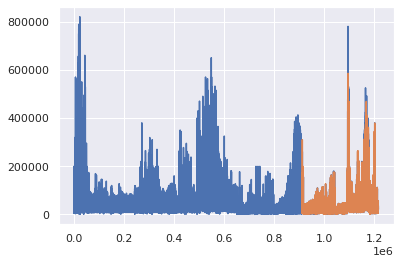

In [6]:
plt.plot(train_df['transaction_real_price'])
plt.plot(concat_df['pred'])

In [14]:
matplotlib.__file__

'/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/__init__.py'

In [1]:
import matplotlib
import matplotlib.font_manager

[f.fname for f in matplotlib.font_manager.fontManager.ttflist]

['/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf',
 '/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf',
 '/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf',
 '/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf',
 '/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf',
 '/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf',
 '/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf',
 '/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf',
 '/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldObl

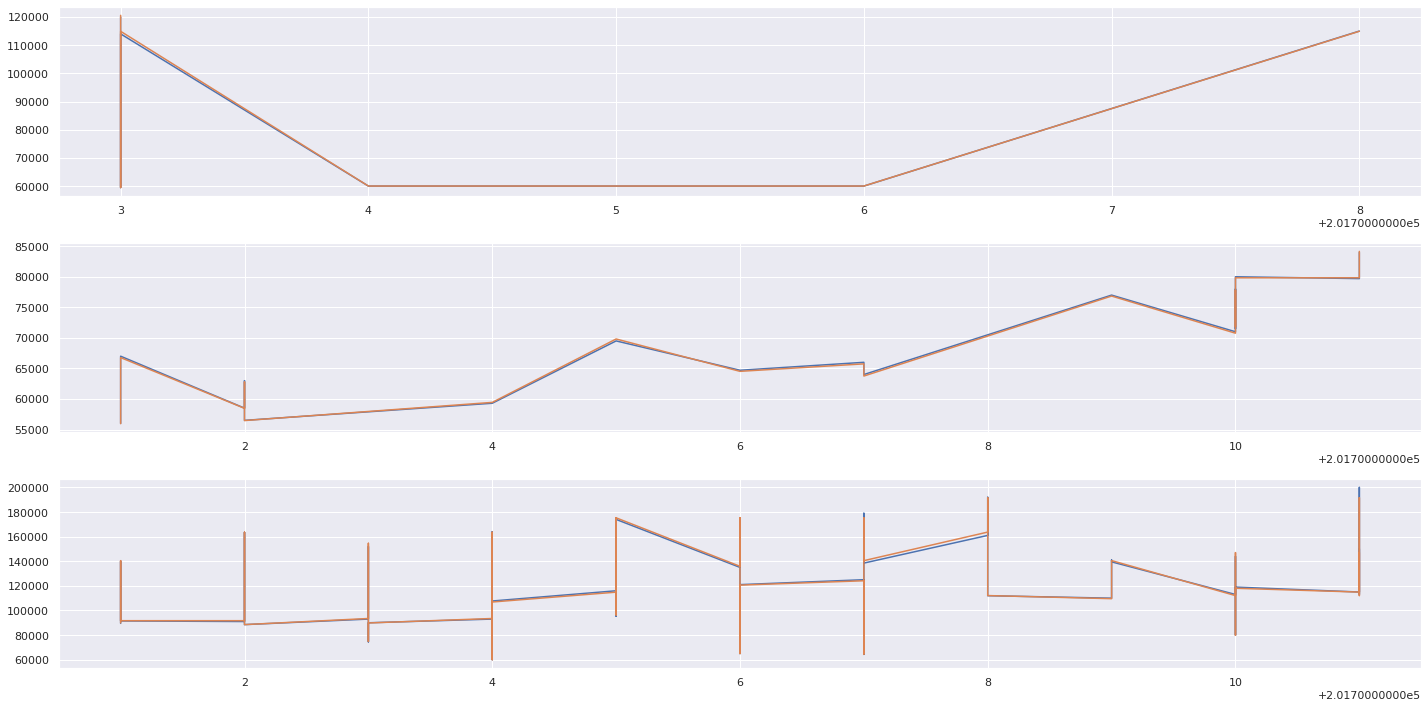

In [8]:
apt = 0
f, ax = plt.subplots(3, 1, figsize=(20, 10))
dong_list = train_df.loc[train_df['apt']==apt, 'dong'].unique()
for i, dong in enumerate(dong_list):
    ax[i].plot(
        train_df[len(tr):].loc[(train_df['apt']==apt) & (train_df['dong']==dong), 'transaction_year_month'],
        train_df[len(tr):].loc[(train_df['apt']==apt) & (train_df['dong']==dong), 'transaction_real_price'],
        concat_df[len(tr):].loc[(concat_df['apt']==apt) & (concat_df['dong']==dong), 'transaction_year_month'],
        concat_df[len(tr):].loc[(concat_df['apt']==apt) & (concat_df['dong']==dong), 'pred'],
        )
    # ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [9]:
concat_df

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,average_price,pred
0,1,138,23,84.8200,41,200801,6,37500,0,10.532123,4.452252,37500.0,NaN
1,1,65,23,99.1700,12,200801,10,20000,0,9.903538,4.606869,29250.0,NaN
2,1,65,23,84.7400,46,200801,10,38500,0,10.558439,4.451319,29250.0,NaN
3,1,13,23,146.3900,42,200801,19,118000,0,11.678448,4.993082,119000.0,NaN
4,1,13,23,194.4300,43,200801,7,120000,0,11.695255,5.275202,119000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,51,201711,7,22000,0,9.998843,4.107993,27615.0,21994.980148
1216549,0,305,23,84.9923,51,201711,11,30750,0,10.333678,4.454258,27615.0,30720.762788
1216550,0,305,23,84.9923,51,201711,13,29500,0,10.292179,4.454258,27615.0,29489.416439
1216551,0,305,10,101.7400,47,201711,11,26700,1,10.192456,4.632202,26850.0,26725.695046


In [10]:
print(plt.rcParams['font.family']) 
plt.rcParams["font.family"] = 'NanumGothic'
print(plt.rcParams['font.family'])

['sans-serif']
['NanumGothic']


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49437 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/kok/anaconda3/envs/rjs/lib/python3.8/site-packages/matplotlib/backends/backend_agg

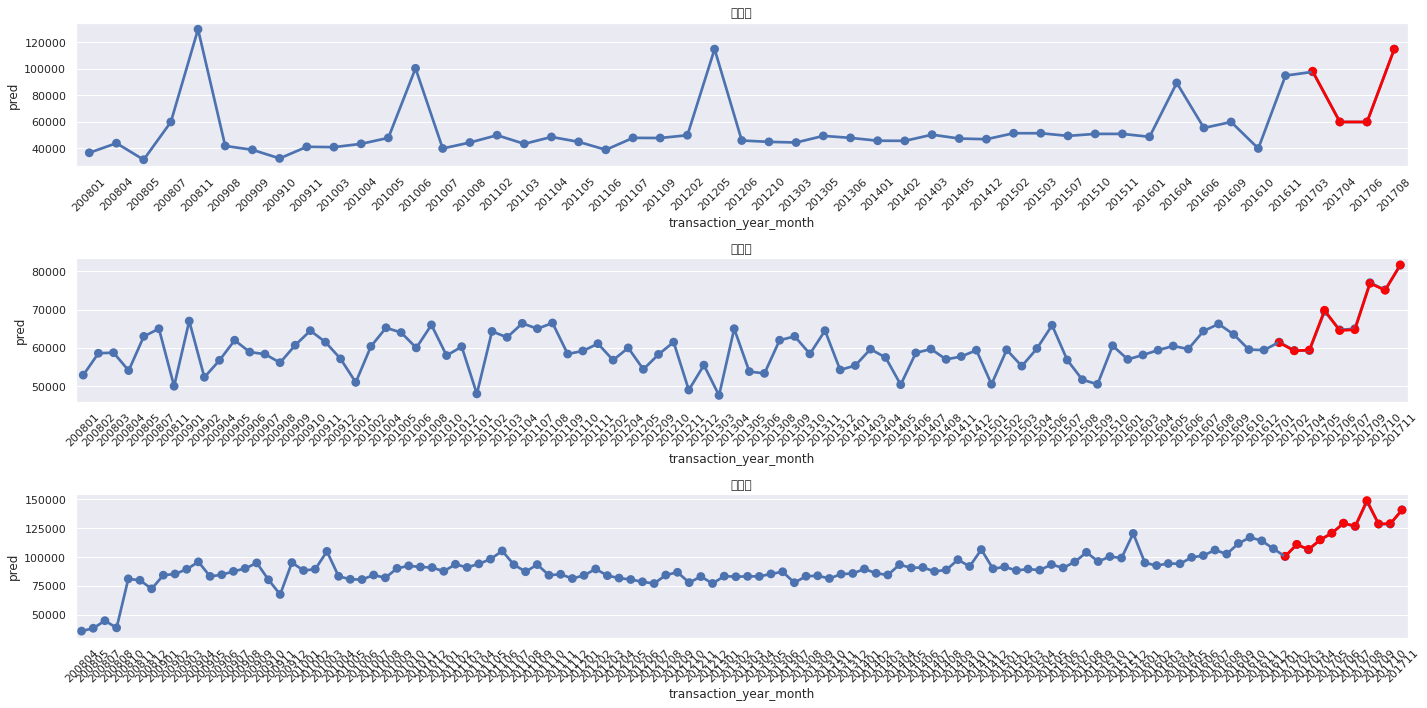

In [11]:
f, ax = plt.subplots(3, 1, figsize=(20, 10))
dong_list = train_df.loc[train_df['apt']==0, 'dong'].unique()
for i, dong in enumerate(dong_list):
    sns.pointplot(x='transaction_year_month', y='average_price', data=train_df.loc[(train_df['apt']==0) & (train_df['dong']==dong)], ax=ax[i])
    sns.pointplot(x='transaction_year_month', y='pred', data=concat_df.loc[(concat_df['apt']==0) & (concat_df['dong']==dong)], ax=ax[i], color='red', ci=None)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    ax[i].set_title(dong_dict[dong])
plt.tight_layout()
plt.show()

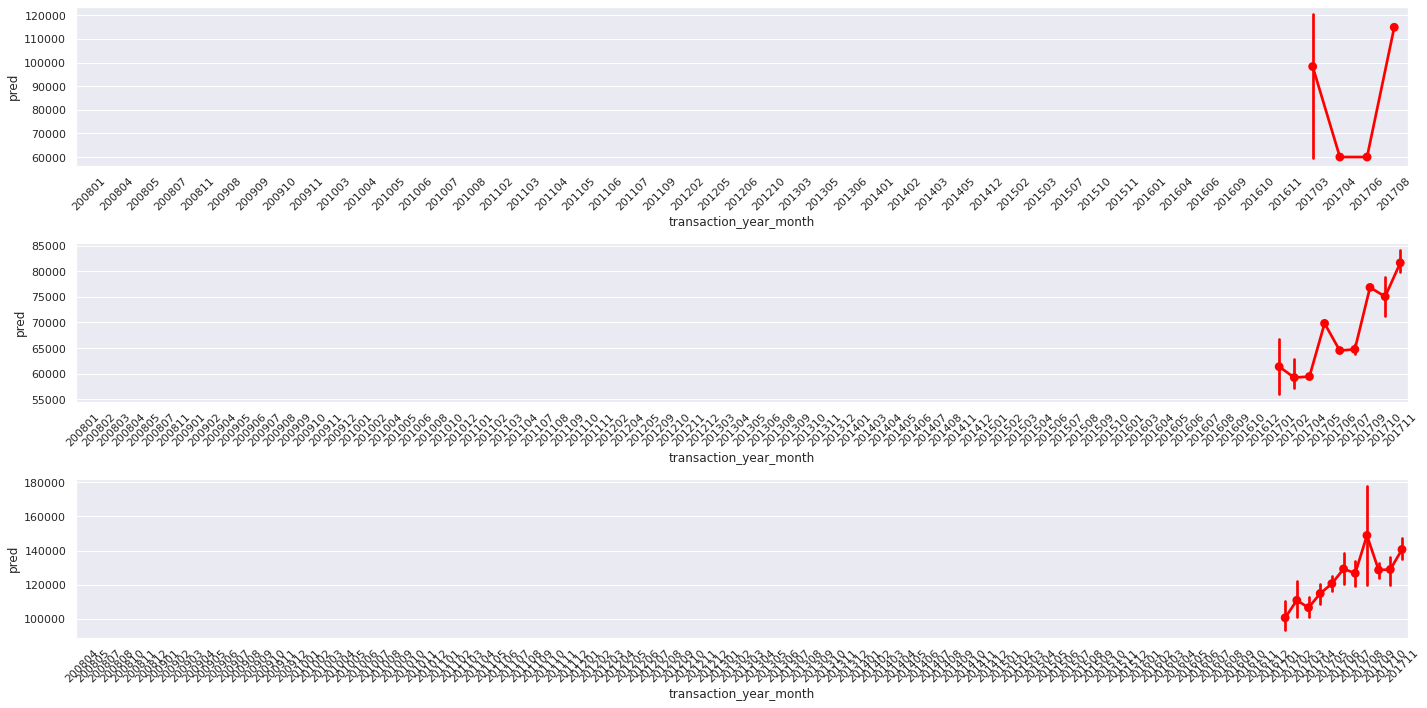

In [12]:
f, ax = plt.subplots(3, 1, figsize=(20, 10))
dong_list = train_df.loc[train_df['apt']==0, 'dong'].unique()
for i, dong in enumerate(dong_list):
    # sns.pointplot(x='transaction_year_month', y='average_price', data=train_df.loc[(train_df['apt']==0) & (train_df['dong']==dong)], ax=ax[i])
    sns.pointplot(x='transaction_year_month', y='pred', data=concat_df.loc[(concat_df['apt']==0) & (concat_df['dong']==dong)], ax=ax[i], color='red')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [13]:
concat_df.loc[(concat_df['apt']==0) & (concat_df['dong']==17) & (concat_df['pred'].notnull())]

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,average_price,pred
1171580,1,17,0,59.96,47,201701,7,89500,0,11.402005,4.110218,100454.545455,89846.928432
1171586,1,17,0,59.96,47,201701,9,90000,0,11.407576,4.110218,100454.545455,89846.928432
1171587,1,17,0,84.80,47,201701,15,114000,0,11.643962,4.452019,100454.545455,114879.303597
1171590,1,17,0,119.93,47,201701,30,140000,0,11.849405,4.795212,100454.545455,140505.399729
1171592,1,17,0,59.96,47,201701,19,90000,0,11.407576,4.110218,100454.545455,89848.072155
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178124,1,17,0,84.97,47,201711,26,138000,0,11.835016,4.453998,140870.588235,135919.565542
1178126,1,17,0,84.80,47,201711,14,149000,0,11.911708,4.452019,140870.588235,147058.351046
1178127,1,17,0,119.93,47,201711,14,180000,0,12.100718,4.795212,140870.588235,175399.374810
1178128,1,17,0,84.88,47,201711,5,130000,0,11.775297,4.452951,140870.588235,131206.603054
